# 25. Denoising AutoEncoder

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.utils as utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import numpy as np
import random
import os

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## Load SVHN Data

In [3]:
svhn_train = dsets.SVHN(root='data/',
                        split='train',
                        transform=transforms.ToTensor(),
                        download=True)

svhn_test = dsets.SVHN(root='data/',
                       split='test',
                       transform=transforms.ToTensor(),
                       download=True)

Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/test_32x32.mat


In [4]:
batch_size = 100

train_loader = torch.utils.data.DataLoader(dataset=svhn_train,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=svhn_test,
                                          batch_size=1,
                                          shuffle=False)

In [5]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

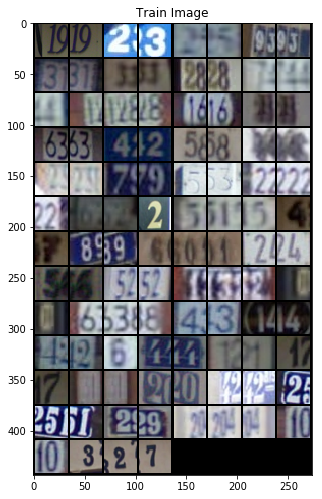

In [6]:
images, labels = iter(train_loader).next()
imshow(torchvision.utils.make_grid(images, normalize=True), "Train Image")

torch.Size([100, 3, 32, 32])
torch.Size([100, 3, 32, 32])


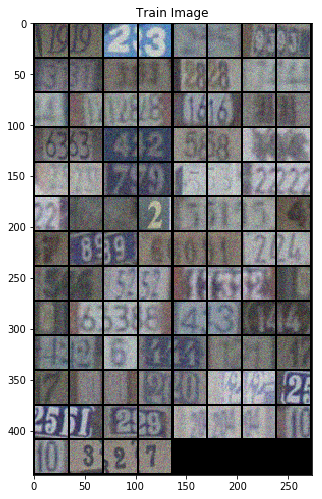

In [7]:
noise = torch.randn(images.size())*0.1
print(noise.size())

noise_X = images + noise
print(noise_X.size())

imshow(torchvision.utils.make_grid(noise_X, normalize=True), "Train Image")

## Define Model

In [8]:
# N: input, F: filter, P: padding, S: stride
def c_conv(N, F, P=0, S=1):
    return int((N+2*P-F)/S+1)

def c_pool(N, F):
    return int(N/F)

# Transposed convolution
def t_conv(N, F, P=0, S=1):
    return int(S*(N-1)+F-2*P)

In [9]:
# Encoder
c0 = 32
c1 = c_conv(c0, 5)
c2 = c_conv(c1, 3)
c3 = c_pool(c2, 2)
c4 = c_conv(c3, 3)
c5 = c_conv(c4, 3)
c6 = c_pool(c5, 2)

print(c0, c1, c2, c3, c4, c5, c6)

# Decoder
c0 = 4
c1 = t_conv(c0, 4, 1, 2)
c2 = t_conv(c1, 4, 1, 2)
c3 = t_conv(c2, 4, 1, 2)

print(c0, c1, c2, c3)

32 28 26 13 11 9 4
4 8 16 32


In [10]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3,16,5),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            
            nn.Conv2d(16,32,3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(32,64,3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            nn.Conv2d(64,128,3),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        
    def forward(self, x):
        z = self.encoder(x)
        
        return z

In [11]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128,64,4,stride=2,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            nn.ConvTranspose2d(64,32,4,stride=2,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            nn.ConvTranspose2d(32,3,4,stride=2,padding=1),
            nn.ReLU()
        )
        
    def forward(self, z):
        out = self.decoder(z)
        out = out.view(-1,3,32,32)
        
        return out

In [12]:
E = Encoder().cuda()
D = Decoder().cuda()

## Training

In [13]:
loss = nn.MSELoss()
optimizer = optim.Adam(list(E.parameters()) + list(D.parameters()), lr=0.001)

In [14]:
num_epochs = 10

for epoch in range(num_epochs):
    
    total_batch = len(svhn_train) // batch_size
    
    for i, (batch_images, batch_labels) in enumerate(train_loader):
        
        X = batch_images.cuda()
        
        noise = (torch.randn(X.size())*0.1).cuda()
        
        noise_X = X + noise
        
        pred = D(E(noise_X))    # noised image 학습
        cost = loss(pred, X)    # cost는 original image와 비교
        
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        
        if (i+1) == total_batch:
            print('Epoch [%d/%d], lter [%d/%d] Loss: %.4f'%(epoch+1, num_epochs, i+1, total_batch, cost.item()))
    
print("Learning Finished!")

Epoch [1/10], lter [732/732] Loss: 0.0089
Epoch [2/10], lter [732/732] Loss: 0.0075
Epoch [3/10], lter [732/732] Loss: 0.0069
Epoch [4/10], lter [732/732] Loss: 0.0066
Epoch [5/10], lter [732/732] Loss: 0.0064
Epoch [6/10], lter [732/732] Loss: 0.0062
Epoch [7/10], lter [732/732] Loss: 0.0059
Epoch [8/10], lter [732/732] Loss: 0.0059
Epoch [9/10], lter [732/732] Loss: 0.0058
Epoch [10/10], lter [732/732] Loss: 0.0056
Learning Finished!


## Test

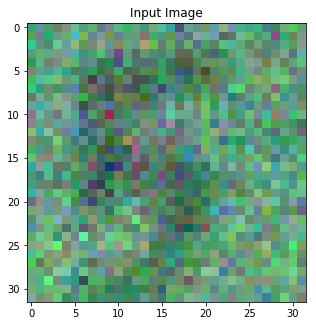

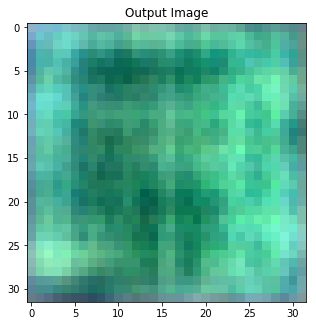

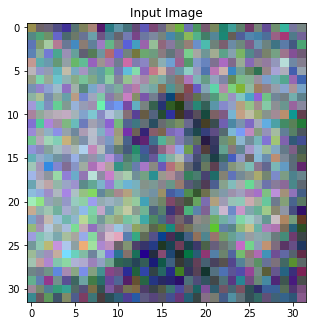

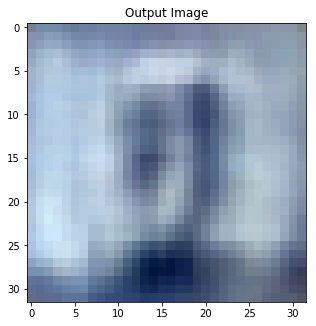

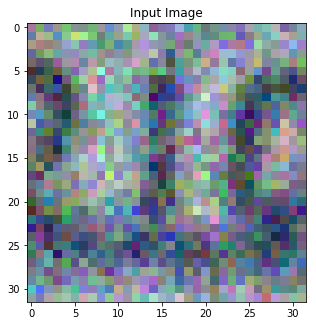

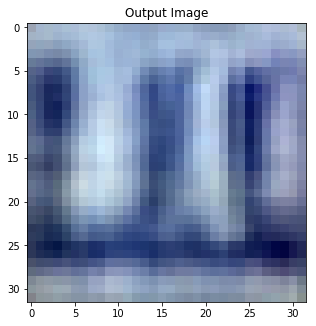

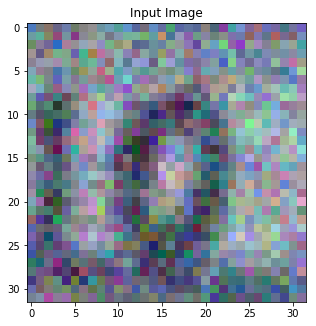

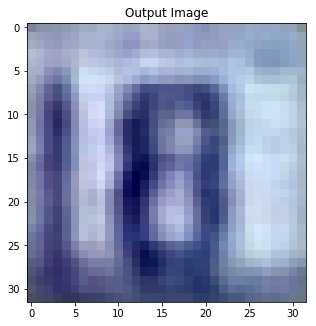

In [15]:
E.eval()
D.eval()

for n, (images, labels) in enumerate(test_loader):
    
    images = images.cuda()
    
    noise = (torch.randn(images.size())*0.1).cuda()
    
    noise_images = images + noise
    
    imshow(torchvision.utils.make_grid(noise_images.data.cpu(), normalize=True), "Input Image")
    
    noise_images = noise_images.view(-1, 3, 32, 32)
    
    outputs = D(E(noise_images))
    outputs = outputs.view(-1, 3, 32, 32)
    
    imshow(torchvision.utils.make_grid(outputs.data.cpu(), normalize=True), "Output Image")
    
    if n > 2 : break